### Predict device failures
This is a program to predict failure of devices used in telemetry. The data was downloaded from here: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv
<br>
I downloaded the data and saved in: /Users/valentin/GoogleDrive/Data/aws/device_failure.csv

##### Goal:
You are tasked with building a predictive model using machine learning to predict the
probability of a device failure. When building this model, be sure to minimize false positives and
false negatives. The column you are trying to predict is called failure with binary value 0 for
non-failure and 1 for failure.


#### Plan for development
1. Read the data
2. EDA of the data
    * Calculate the distribution of total fail/not fail cases
    * Distribution of fail/not-fail cases by year
    * Distribution of fail/not-fail cases by month
    * Are there any devices that have higher failure rates than others
    * When a device fails, does it disappear from the data, or 
3. Determine which features are categorical, and if needed create dummies
4. Derive new features
    * Use decision trees to decide how to split by categories of attributes
    * Should I do PCA? (likely no..)
4. Sampling of the data (70/30)
    * Create random samples from the data - 70% for training and 30% for validation
    * If the cases are too few compared to the non-cases, I may need to oversample the cases, or simply undersample the non-cases
7. Variables reduction
    * Use p-values
    * LASSO
    * Random forest's variable importance
    * Stepwise logistic regression
    * Compare the suggested features from each method
8. Decide on a methodology for the model estimation
    * Random forest
    * SVM
    * Survival analysis
9. Validate the results
10. Calculate c-statistic and ROC
11. Create a confusion matrix - reduce false positives and false negatives
12. Does the methodology we use allow us to understand what drives the outcome? If it doesn't, do we need another methodology that can help with that?


In [231]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read in the data and print out the header
device_data = pd.read_csv("/Users/valentin/GoogleDrive/Data/aws/device_failure.csv")

# Check if the number of rows is as expected
print (len(device_data))

device_data.head(10)

124494


date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   
5  2015-01-01  S1F01TD5        0    68837488           0           0   
6  2015-01-01  S1F01XDJ        0   227721632           0           0   
7  2015-01-01  S1F023H2        0   141503600           0           0   
8  2015-01-01  S1F02A0J        0     8217840           0           1   
9  2015-01-01  S1F02DZ2        0   116440096           0         323   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3  
5          41           6      413535           0           0           1  
6           0           8      402525           0           0           0  
7           1          19      494462          16          16           3  
8           0          14      311869           0           0           0  
9           9           9      407905           0           0         164

In [228]:
# Calculate the distribution of total fail/not fail cases
pct_fail_cases = sum(device_data["failure"]) / len(device_data["failure"]) * 100
print("It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.")
print("Only %s of the cases are device failures" % pct_fail_cases)

It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.
Only 0.0851446656064 of the cases are device failures


We need to dig a little deeper into the distributions of failure/non-failure and understand the following:
1. Distribution of failure/non-failure by year
2. Distribution of failure/non-failure by month
3. Distribution of failure/non-failure by device - are there specific devices that tend to fail more than others?

In [229]:
# Distribution of failure/non-failure by year
device_data["year"] = pd.to_datetime(device_data["date"]).dt.year
device_data["month"] = pd.to_datetime(device_data["date"]).dt.month

print(pd.crosstab(device_data["year"],
                  columns = "count"))
pd.crosstab(device_data["month"],
            columns = "count") / len(device_data.month)

col_0   count
year         
2015   124494


col_0     count
month          
1      0.201070
2      0.156634
3      0.159309
4      0.096487
5      0.091008
6      0.084092
7      0.084590
8      0.067039
9      0.035905
10     0.023616
11     0.000249

It is evident that the data is only for 2015 and we have information for most of the months of 2015, except for December. However, note that 50% of the observations are from the period January - March.
<p>
Next, we'll look at the distribution of failure/non-failure by month

In [151]:
# Distribution of failure/non-failure by month
failure_month = pd.crosstab(index = device_data["failure"],
                            columns = device_data["month"],
                            margins = True)

failure_month.index = ["non_failure", "failure", "month_total"]
failure_month

month            1      2      3      4      5      6      7     8     9  \
non_failure  25008  19486  19824  12003  11309  10463  10515  8342  4470   
failure         24     14      9      9     21      6     16     4     0   
month_total  25032  19500  19833  12012  11330  10469  10531  8346  4470   

month          10  11     All  
non_failure  2937  31  124388  
failure         3   0     106  
month_total  2940  31  124494

In [152]:
failure_month_pct = failure_month / failure_month.ix["month_total"]
failure_month_pct

month               1         2         3         4         5         6  \
non_failure  0.999041  0.999282  0.999546  0.999251  0.998147  0.999427   
failure      0.000959  0.000718  0.000454  0.000749  0.001853  0.000573   
month_total  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

month               7         8    9       10   11       All  
non_failure  0.998481  0.999521  1.0  0.99898  1.0  0.999149  
failure      0.001519  0.000479  0.0  0.00102  0.0  0.000851  
month_total  1.000000  1.000000  1.0  1.00000  1.0  1.000000

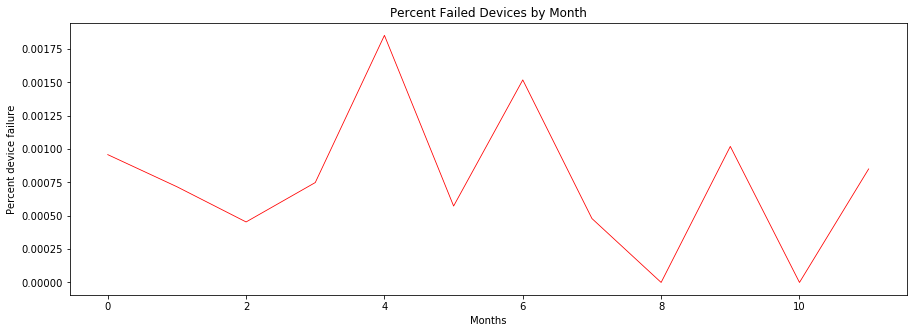

In [153]:
# Plot the % failures/non-failures by month
plt.figure(figsize = (15, 5))
plt.plot(list(failure_month_pct.ix["failure"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

In [165]:
failure_day = pd.crosstab(index = device_data["date"],
                          columns = device_data["failure"],
                          margins = True)

failure_day.columns = ["non_failure", "failure", "total"]
failure_day

non_failure  failure   total
date                                    
2015-01-01         1163        0    1163
2015-01-02         1163        0    1163
2015-01-03         1163        0    1163
2015-01-04         1162        0    1162
2015-01-05         1160        1    1161
2015-01-06         1054        0    1054
2015-01-07          797        1     798
2015-01-08          756        0     756
2015-01-09          755        1     756
2015-01-10          755        0     755
2015-01-11          755        0     755
2015-01-12          755        0     755
2015-01-13          754        1     755
2015-01-14          715        1     716
2015-01-15          715        0     715
2015-01-16          715        0     715
2015-01-17          714        1     715
2015-01-18          713        1     714
2015-01-19          705        8     713
2015-01-20          712        1     713
2015-01-21          712        0     712
2015-01-22          711        1     712
2015-01-23          710        2     712
2015-01-24          712        0     712
2015-01-25          712        0     712
2015-01-26          711        1     712
2015-01-27          711        1     712
2015-01-28          711        1     712
2015-01-29          713        2     715
2015-01-30          712        0     712
...                 ...      ...     ...
2015-10-03          146        0     146
2015-10-04          146        0     146
2015-10-05          145        1     146
2015-10-06          141        0     141
2015-10-07          141        0     141
2015-10-08          141        0     141
2015-10-09          140        1     141
2015-10-10          140        0     140
2015-10-11          140        0     140
2015-10-12          140        0     140
2015-10-13          111        0     111
2015-10-14          111        0     111
2015-10-15          109        0     109
2015-10-16          109        0     109
2015-10-17          109        0     109
2015-10-18          109        0     109
2015-10-19          109        0     109
2015-10-20           69        0      69
2015-10-21           69        0      69
2015-10-22           69        0      69
2015-10-23           32        0      32
2015-10-24           32        0      32
2015-10-25           32        0      32
2015-10-26           31        1      32
2015-10-27           31        0      31
2015-10-29           31        0      31
2015-10-30           31        0      31
2015-10-31           31        0      31
2015-11-02           31        0      31
All              124388      106  124494

[305 rows x 3 columns]

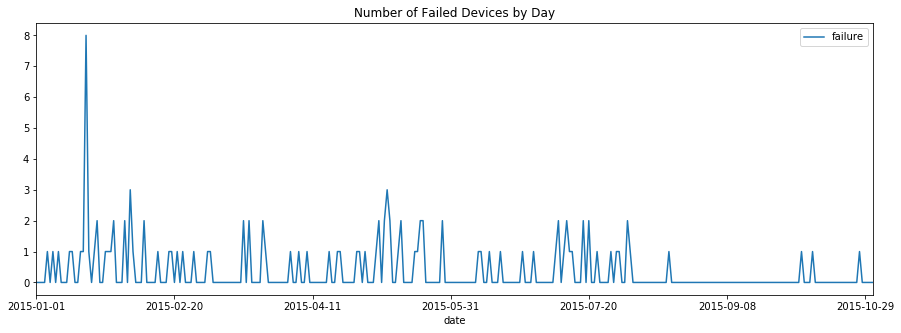

In [226]:
# Plot the % failures/non-failures by day
failure_day[:-1].reset_index().plot(x = "date", y = "failure",
                                    figsize = (15, 5),
                                    title = "Number of Failed Devices by Day")

In [236]:
# Distribution of failure/non-failure by device - are there specific devices that tend to fail more than others?
failure_devices = pd.crosstab(index = device_data["device"],
                              columns = device_data["failure"],
                              margins = True)
failure_devices.columns = ["non_failure", "failure", "total"]
failure_devices

non_failure  failure   total
device                                
S1F01085            6        0       6
S1F013BB            6        0       6
S1F0166B            6        0       6
S1F01E6Y           48        0      48
S1F01JE0            6        0       6
S1F01R2B          223        0     223
S1F01TD5            6        0       6
S1F01XDJ          106        0     106
S1F023H2           18        1      19
S1F02A0J          227        0     227
S1F02DZ2            6        0       6
S1F02EVN            6        0       6
S1F02L38           86        0      86
S1F02MGA            6        0       6
S1F02P76            6        0       6
S1F02VAX            6        0       6
S1F02W1L            6        0       6
S1F02WFT            6        0       6
S1F02XLX            6        0       6
S1F0318A            6        0       6
S1F0322R            6        0       6
S1F0330P            6        0       6
S1F03499            6        0       6
S1F035SJ            6        0       6
S1F0377V            6        0       6
S1F039FE            6        0       6
S1F03RV3            5        0       5
S1F03YZM          214        1     215
S1F044ET          236        0     236
S1F049RX            6        0       6
...               ...      ...     ...
Z1F1A0RP          295        0     295
Z1F1A1HH          295        0     295
Z1F1A7MG            6        0       6
Z1F1A83K          112        0     112
Z1F1AD0M           82        0      82
Z1F1AF54            6        0       6
Z1F1AFF2           84        0      84
Z1F1AFT5            6        0       6
Z1F1AG5N            8        1       9
Z1F1AGLA            5        0       5
Z1F1AGN5            5        0       5
Z1F1AGW1            5        0       5
Z1F1B6H4            6        0       6
Z1F1B6NP          292        0     292
Z1F1B799          245        0     245
Z1F1CZ35          103        0     103
Z1F1FCH5           18        1      19
Z1F1FZ9J           48        0      48
Z1F1HEQR            6        0       6
Z1F1HSWK            6        0       6
Z1F1Q9BD           82        0      82
Z1F1R76A          245        0     245
Z1F1RE71            6        0       6
Z1F1RJFA          123        1     124
Z1F1VMZB          292        0     292
Z1F1VQFY          124        1     125
Z1F26YZB           84        0      84
Z1F282ZV           84        0      84
Z1F2PBHX           83        0      83
All            124388      106  124494

[1169 rows x 3 columns]

In [237]:
failure_devices.loc[failure_devices["failure"] == 1]

non_failure  failure  total
device                               
S1F023H2           18        1     19
S1F03YZM          214        1    215
S1F09DZQ          198        1    199
S1F0CTDN            6        1      7
S1F0DSTY           44        1     45
S1F0F4EB          126        1    127
S1F0GG8X           17        1     18
S1F0GJW3           75        1     76
S1F0GKFX          116        1    117
S1F0GKL6          132        1    133
S1F0GPFZ          204        1    205
S1F0GSD9          147        1    148
S1F0GSHB          214        1    215
S1F0J5JH          192        1    193
S1F0JD7P           98        1     99
S1F0JGJV          277        1    278
S1F0L0DW          140        1    141
S1F0LCTV           25        1     26
S1F0LCVC          117        1    118
S1F0LD15          200        1    201
S1F0LD2C           75        1     76
S1F0P3G2           19        1     20
S1F0PJJW           59        1     60
S1F0QF3R          147        1    148
S1F0QY11           18        1     19
S1F0RR35           86        1     87
S1F0RRB1            4        1      5
S1F0RSZP          110        1    111
S1F0S2WJ           18        1     19
S1F0S4CA           57        1     58
...               ...      ...    ...
W1F1BS0H          189        1    190
W1F1BZTM          119        1    120
W1F1C9TE           53        1     54
W1F1C9WG          126        1    127
W1F1CB5E          215        1    216
W1F1CDDP           92        1     93
W1F1CJ1K          193        1    194
W1F1DQN8          211        1    212
Z1F04GCH           49        1     50
Z1F0B4XZ          117        1    118
Z1F0FSBY           77        1     78
Z1F0K451          130        1    131
Z1F0LSNZ          176        1    177
Z1F0LVGY           34        1     35
Z1F0LVPW           18        1     19
Z1F0MCCA           34        1     35
Z1F0MRPJ          229        1    230
Z1F0NVZA           18        1     19
Z1F0P16F          188        1    189
Z1F0P5D9           35        1     36
Z1F0QH0C           82        1     83
Z1F130LH           63        1     64
Z1F148T1          109        1    110
Z1F14BGY          281        1    282
Z1F1653X          127        1    128
Z1F1901P          131        1    132
Z1F1AG5N            8        1      9
Z1F1FCH5           18        1     19
Z1F1RJFA          123        1    124
Z1F1VQFY          124        1    125

[106 rows x 3 columns]

In [210]:

len(pd.to_datetime(device_data["date"]).dt.month)

dd = failure_day[:-1]